In [ ]:
!pip install darts

In [ ]:
train_for = 735

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
print(df.columns)
print(df.state_residence.unique())
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()
df.head()


date = df.iloc[train_for + 1]['Date']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['Unnamed: 0', 'state_residence', 'district_residence', 'Date', '<15',
       '15-24', '25-34', '35-44', '45-59', '60-80', '>80', '<15_pos',
       '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos',
       '>80_pos', 'M_pos', '2', 'F_pos', 'T', 'F', 'M', 'NIA', 'T_pos',
       'NIA_pos', 'O', 'O_pos', 'N', 'G', ',', 'D', 'new_case',
       'negative_case', 'Failed_test', 'Total_test',
       'negative_egene_screening', 'positive_egene_screening',
       'Failed_test_egene_screening', '<20_ct_value_screening',
       '20-30_ct_value_screening', '31-35_ct_value_screening',
       '>35_ct_value_screening', '<20_posct_value_screening',
       '20-30_posct_value_screening', '31-35_posct_value_screening',
       '>35_posct_value_screening', 'negative_rdrp_confirmatory',
       'positive_rdrp_confirmatory', 'Failed_test_rdrp_confirmatory',
      

In [ ]:
from darts.models import TCNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd

In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

df_f = smoothen(df_f, 3)
df_m = smoothen(df_m, 3)
df_t = smoothen(df_t, 3)
df_nia = smoothen(df_nia, 3)

df = df_f + df_m + df_t + df_nia


# n = 70  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# df_total = lfilter(b, a, df_total)
# df = smoothen(df, 3)


series = TimeSeries.from_values(df)

In [ ]:
predict_for = 14
window_size= 50
train, test = series[:train_for], series[train_for:train_for+predict_for]

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.0000000001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [ ]:
model = TCNModel(
    input_chunk_length = window_size,
    output_chunk_length = 1,
    pl_trainer_kwargs = pl_trainer_kwargs,
    kernel_size = 3,
    dropout=0.15
)

In [ ]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [ ]:
model.fit(
    scaled_train,
    epochs = 100
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 212   
----------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_TCN = model.predict(n=predict_for)

pred_TCN = train_scaler.inverse_transform(scaled_pred_TCN)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
def mape_(p, a):
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
mape_TCN = mape_(pred_TCN, test)

print(mape_TCN)

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[33.50883866]]])
Coordinates:
  * time       (time) int64 0
  * component  (component) object '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [ ]:
model.save("model_" + date + ".pt")

In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


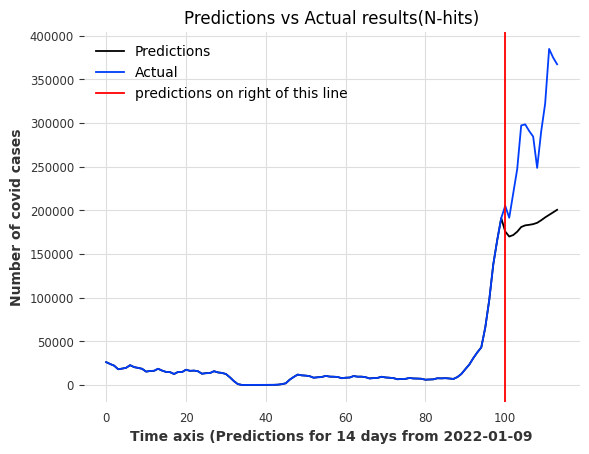

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results(N-hits)")
plt.plot(append(df[train_for - window:train_for], pred_TCN.pd_dataframe().values), label="Predictions")
plt.plot(append(df[train_for - window:train_for], test.pd_dataframe().values), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(test.pd_dataframe().values.reshape(-1))

[205228.         191578.66666667 219443.33333333 247295.66666667
 297296.         298543.         290942.33333333 284577.
 248668.33333333 290140.         322144.33333333 384948.33333333
 375075.66666667 367394.33333333]


In [ ]:
print(pred_TCN.pd_dataframe().values.reshape(-1))

[175766.76226876 170074.88943095 171742.02826974 175566.84323282
 180959.45212418 182857.59560041 183455.18347215 184261.65348337
 185765.98193155 188653.38504146 191960.12968491 194872.36344165
 197738.35309395 200666.86591797]
